In [5]:
import pandas as pd
import numpy as np
# import seaborn as sns
# %matplotlib inline

# Plot average automation measures by certain technologies

measures:
    - change in automation
    - % change in automation
    - automation, absolute level
    - change in certain skills
    - skill level

# AUTOMATION (1/2)

In [6]:
adoptions = pd.read_csv('../../../data/tech_adoptions.csv')
a = pd.read_csv('../../../data/helpers/automation_targets.csv').drop('Unnamed: 0', axis = 1)

IOError: File ../../../data/tech_adoptions.csv does not exist

In [3]:
merged = adoptions.merge(a, on = 'O*NET-SOC Code', how = 'inner')

In [4]:
# gb:
    # example
    # broad_group
    # minor_group
    # major_group

In [5]:
merged.columns

Index([u'O*NET-SOC Code', u'T2 Type', u'T2 Example', u'Commodity Code',
       u'Commodity Title', u'Title_x', u'broad_group', u'minor_group',
       u'major_group', u'broad_title', u'minor_title', u'major_title',
       u'segment_code', u'class_code', u'family_code', u'class_title',
       u'family_title', u'segment_title', u'automation_15', u'automation_9',
       u'delta', u'delta_pct', u'Title_y'],
      dtype='object')

In [6]:
def output_chart(df, grouping_column, outcome, graph = True, n = 10):
    """
    groupings: {'jobs': ['Title_x', 'broad_title', 'minor_title', 'major_title'],
                'tech': ['T2 Example', 'class_title', 'family_title', 'segment_title']}
    """
    
    gb = df.groupby(grouping_column)[[grouping_column, outcome]].mean().reset_index()
    top_n = gb.sort_values(by = outcome, ascending = False).head(n)
    bottom_n = gb.sort_values(by = outcome).head(n)    
    if graph:
        num_values = len(df[grouping_column].unique())
        top_n.plot.bar(x = top_n[grouping_column], title = '{} : Top {}'.format(outcome.upper(), n))
        bottom_n.plot.bar(x = bottom_n[grouping_column], title = '{} : Bottom {}'.format(outcome.upper(), n))
    return top_n, bottom_n

In [7]:
groupings = {'jobs': ['Title_x', 'broad_title', 'minor_title', 'major_title'],
             'tech': ['T2 Example', 'class_title', 'family_title', 'segment_title'],
             'skills': ['sample skills list']}

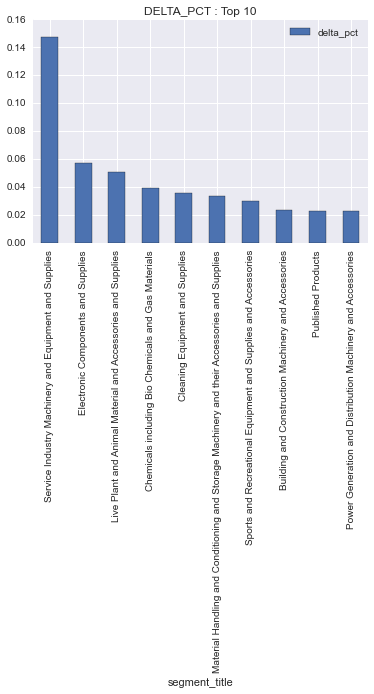

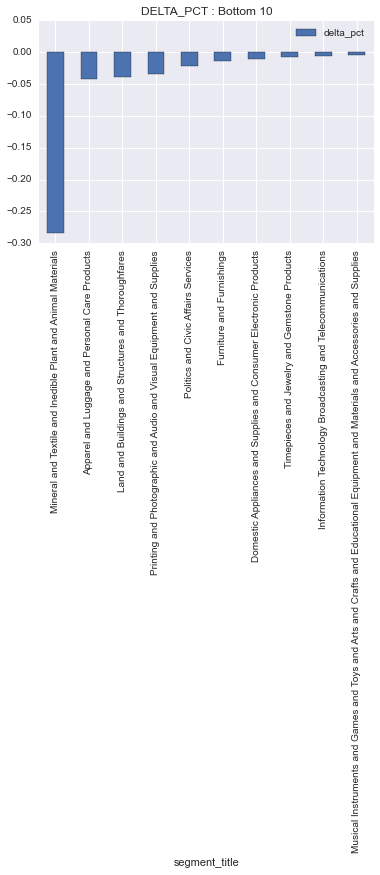

In [8]:
t, b = output_chart(merged, 'segment_title', 'delta_pct')

In [9]:
t.head()

,segment_title,delta_pct
29,Service Industry Machinery and Equipment and S...,0.147600
10,Electronic Components and Supplies,0.057000
17,Live Plant and Animal Material and Accessories...,0.050498
2,Chemicals including Bio Chemicals and Gas Mate...,0.039471
3,Cleaning Equipment and Supplies,0.035558


In [10]:
b.head()

,segment_title,delta_pct
21,Mineral and Textile and Inedible Plant and Ani...,-0.284478
0,Apparel and Luggage and Personal Care Products,-0.041746
16,Land and Buildings and Structures and Thorough...,-0.038462
27,Printing and Photographic and Audio and Visual...,-0.033871
25,Politics and Civic Affairs Services,-0.022059


#∆SKILL gb TECHNOLOGY (2/3)

load skill

In [11]:
s2009 = pd.read_csv('../../../data/helpers/skills/skills_2009.csv')
s2015 = pd.read_table('../../../data/databases/db15/Skills.txt', delimiter = '\t')
s2015 = s2015[s2015['Scale ID'] == 'LV']
s2015 = s2015.pivot_table(values = 'Data Value', index = 'O*NET-SOC Code', columns='Element Name').reset_index()

/Users/Logan/anaconda/envs/dev/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
def read_pivot_table(file_path, delimiter = '\t', scale = 'LV'):
    df = pd.read_table(file_path, delimiter = delimiter)
    df = df[df['Scale ID'] == scale]
    return df.pivot_table(values = 'Data Value', index = 'O*NET-SOC Code', columns='Element Name').reset_index()    

def match_two_dfs(df1, df2, restricting_set = None):
    # if codes not already index:
    if not all(np.equal(df1.index, df1['O*NET-SOC Code'])):
        df1.index = df1['O*NET-SOC Code']
    if not all(np.equal(df2.index, df2['O*NET-SOC Code'])):
        df2.index = df2['O*NET-SOC Code']
        
    # same rows
    row_s1, row_s2 = set(df1['O*NET-SOC Code']), set(df2['O*NET-SOC Code'])
    row_joint = row_s1.intersection(row_s2)
    if restricting_set:
        row_joint = row_joint.intersection(restricting_set)

    # same columns 
    col_s1, col_s2 = set(df1.columns), set(df2.columns)
    col_joint = col_s1.intersection(col_s2)
    
    # filter
    df1, df2 = df1[list(col_joint)], df2[list(col_joint)]
    df1, df2 = df1.loc[row_joint], df2.loc[row_joint]

    # confirm column order
    df1 = df1[df2.columns]
    
    # confirm row order
    df1.index = df1['O*NET-SOC Code']
    df2_order = df2['O*NET-SOC Code']
    df1 = df1.loc[df2_order].reset_index(drop = True)
    
    return df1.reset_index(drop = True), df2.reset_index(drop = True)

In [13]:
a, b = match_two_dfs(s2009, s2015)

In [14]:
# limit to occupations that have adopted
adopted = pd.read_csv('../../../data/tech_adoptions.csv')['O*NET-SOC Code'].unique()
joint = set(s2009['O*NET-SOC Code']).intersection(set(s2015['O*NET-SOC Code'])).intersection(set(adopted))
s9, s15 = s2009[s2009['O*NET-SOC Code'].isin(joint)], s2015[s2015['O*NET-SOC Code'].isin(joint)]

In [15]:
codes = s9.iloc[:, 0]
subbed = np.subtract(s15.iloc[:,1:], s9.iloc[:,1:])
subbed['O*NET-SOC Code'] = codes

In [16]:
skills_list = list(subbed.columns[:-1])

In [17]:
skill_merged = merged.merge(subbed, on = 'O*NET-SOC Code', how = 'inner')

In [18]:
from helpers.helper import *

def get_difference(before, after, method = 'absolute'):
    before, after = match_two_dfs(before, after)
    before_no_code, after_no_code = before.drop('O*NET-SOC Code', axis = 1), after.drop('O*NET-SOC Code', axis = 1)
    codes = before['O*NET-SOC Code']
    if method in ['absolute', 'percent']:
        difference = np.subtract(after_no_code, before_no_code)
    
    if method == 'percent':
        difference = np.divide(difference, before_no_code)
    
    if method == 'ranking':
        p_before, p_after = get_percentiles(before_no_code), get_percentiles(after_no_code)
        difference = np.subtract(p_after, p_before)
    
    difference['O*NET-SOC Code'] = codes
        
    return difference.sort(axis = 1) # returns if absolute

In [19]:
abs_diff = get_difference(s2009, s2015, 'absolute')
pct_diff = get_difference(s2009, s2015, 'percent')
rank_diff = get_difference(s2009, s2015, 'ranking')

/Users/Logan/anaconda/envs/dev/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [20]:
titles = pd.read_csv('../../../data/helpers/occ_codes/names.csv')

In [21]:
def plot_charts(base, skills, grouping = 'segment_title'):
    skills_list = skills.drop('O*NET-SOC Code', axis = 1).columns
    merged = base.merge(skills, on = 'O*NET-SOC Code', how = 'inner')
    for skill in skills_list:
        output_chart(skill_merged, grouping, skill, n = 5)

In [22]:
abs_diff.columns

Index([u'Active Learning', u'Active Listening', u'Complex Problem Solving',
       u'Coordination', u'Critical Thinking', u'Equipment Maintenance',
       u'Equipment Selection', u'Installation', u'Instructing',
       u'Judgment and Decision Making', u'Learning Strategies',
       u'Management of Financial Resources',
       u'Management of Material Resources',
       u'Management of Personnel Resources', u'Mathematics', u'Monitoring',
       u'Negotiation', u'O*NET-SOC Code', u'Operation Monitoring',
       u'Operation and Control', u'Operations Analysis', u'Persuasion',
       u'Programming', u'Quality Control Analysis', u'Reading Comprehension',
       u'Repairing', u'Science', u'Service Orientation',
       u'Social Perceptiveness', u'Speaking', u'Systems Analysis',
       u'Systems Evaluation', u'Technology Design', u'Time Management',
       u'Troubleshooting', u'Writing'],
      dtype='object', name=u'Element Name')

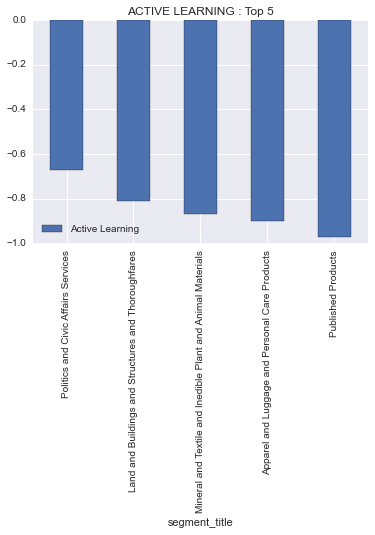

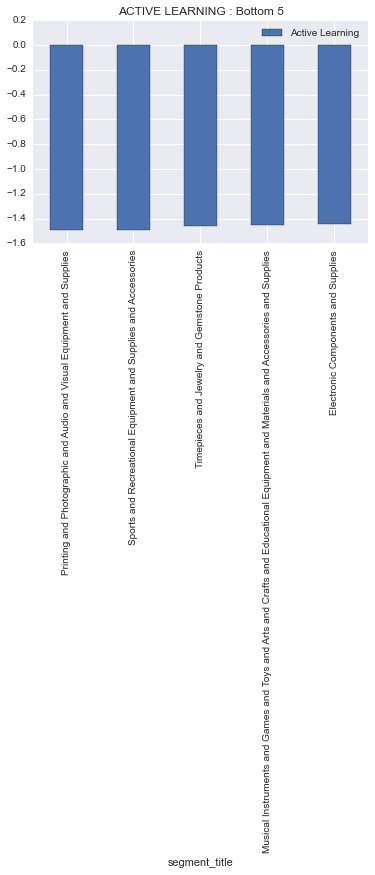

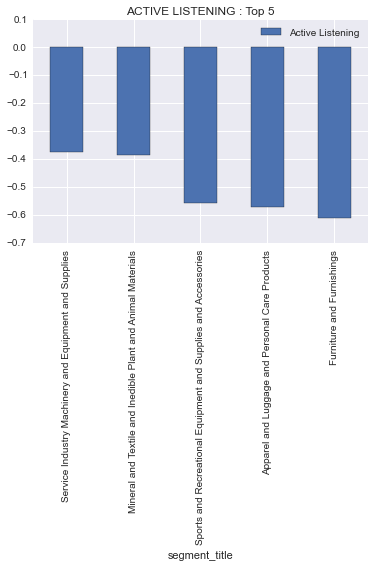

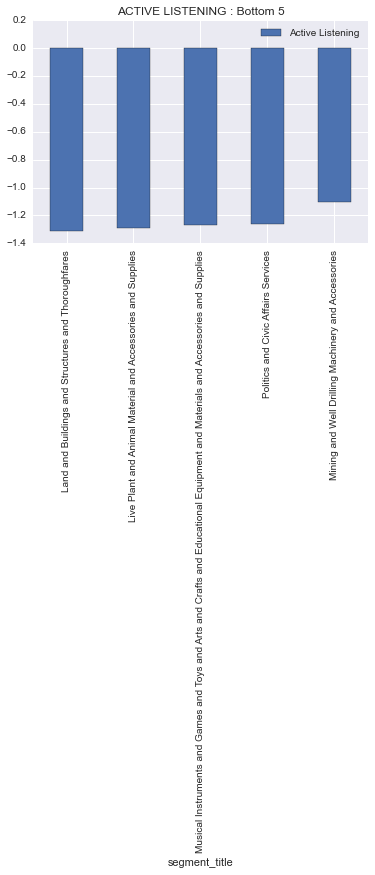

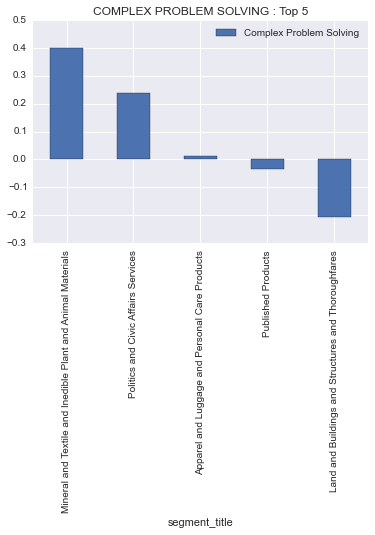

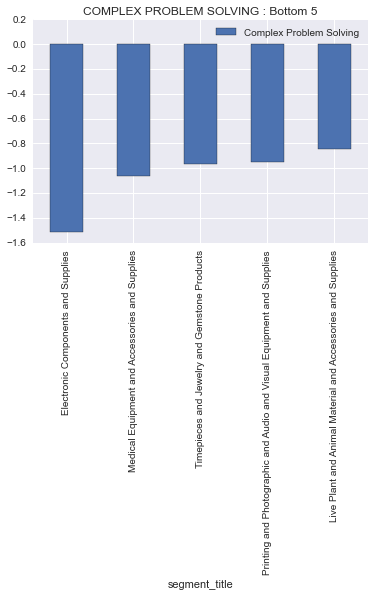

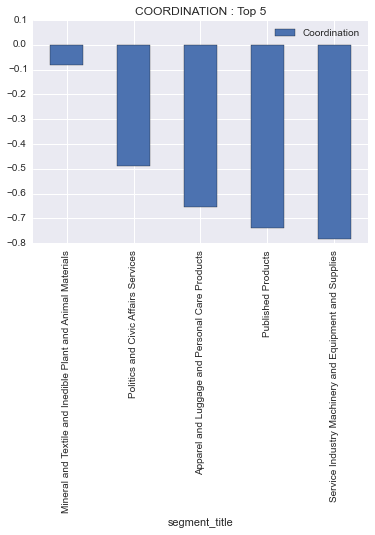

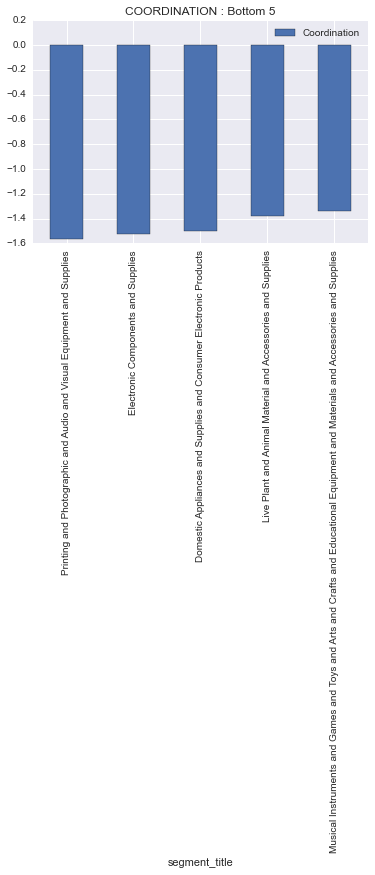

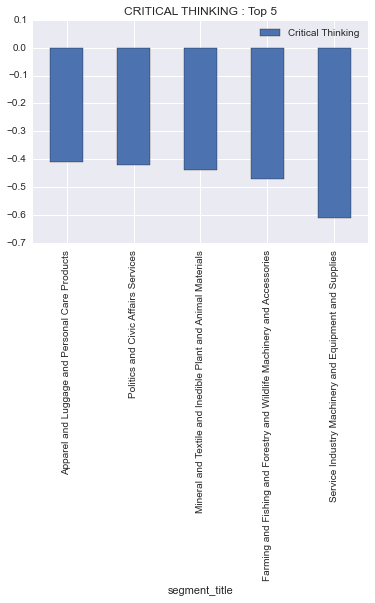

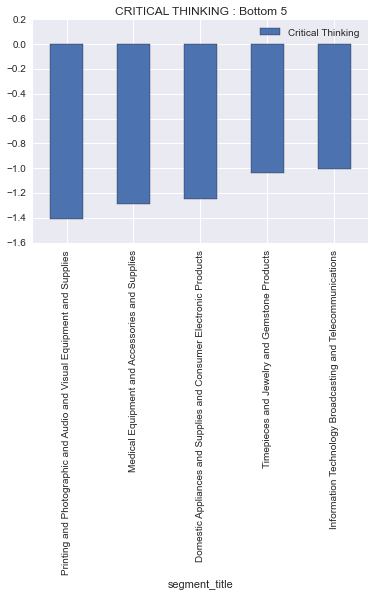

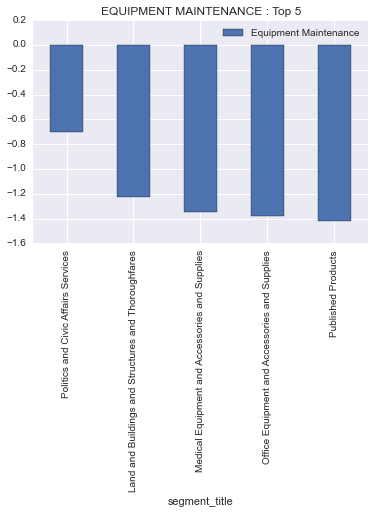

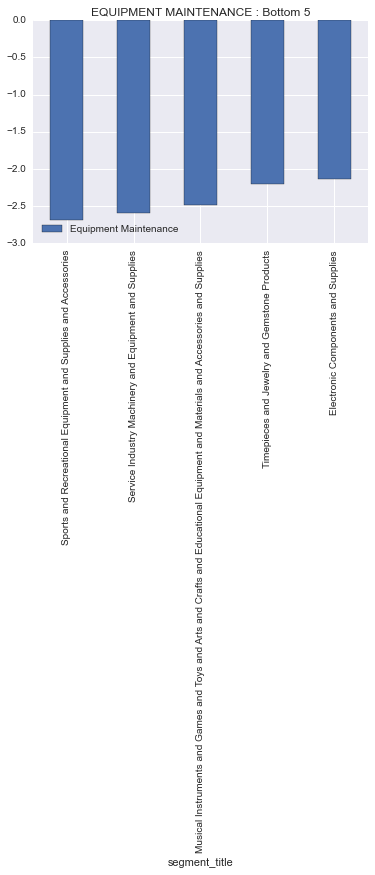

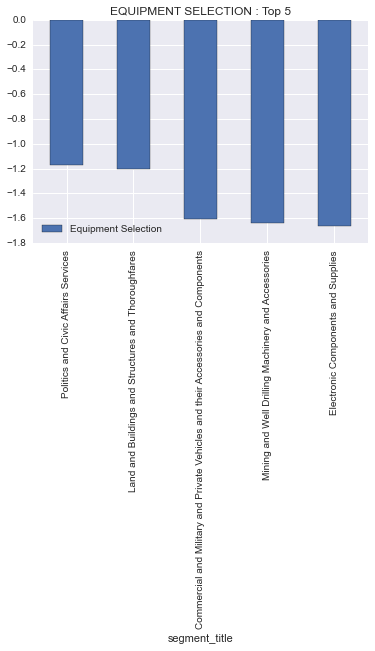

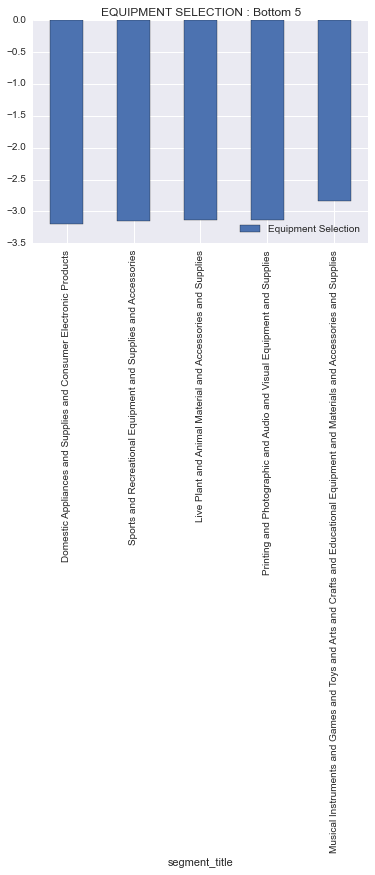

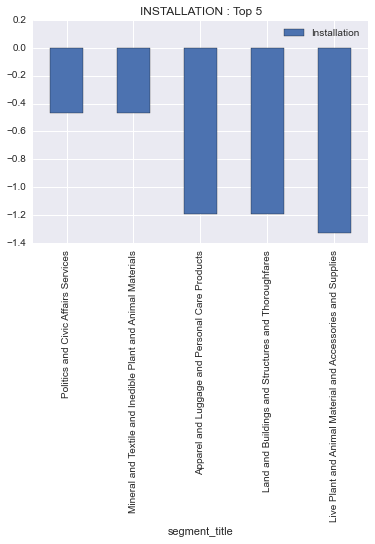

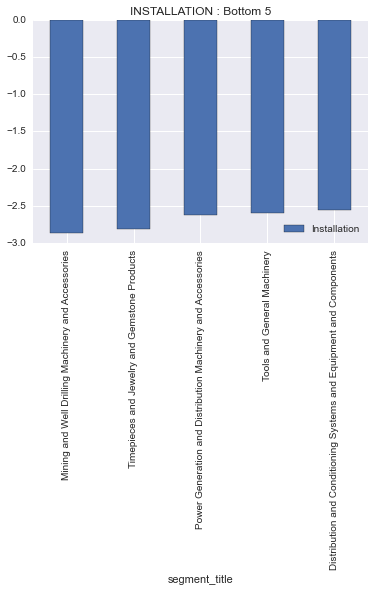

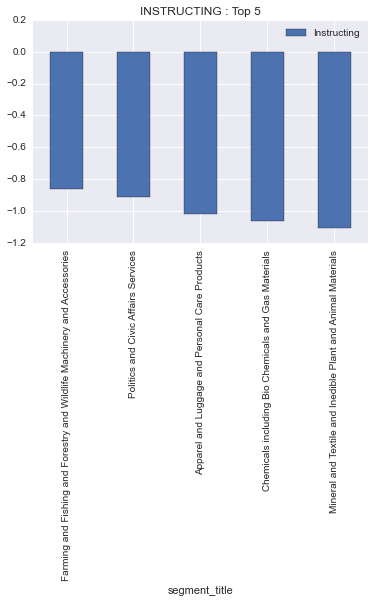

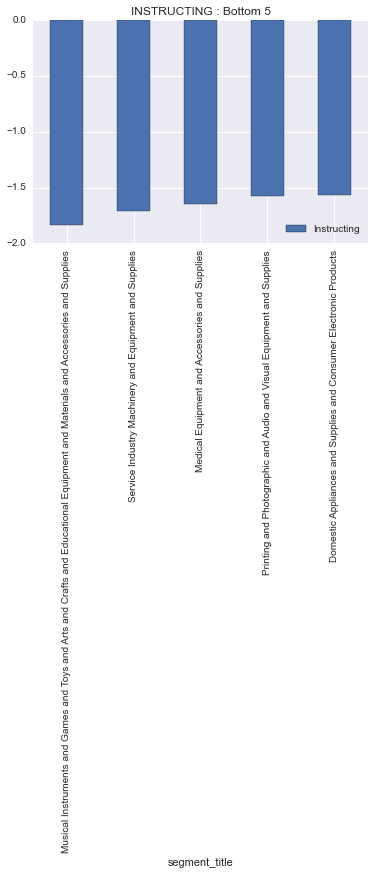

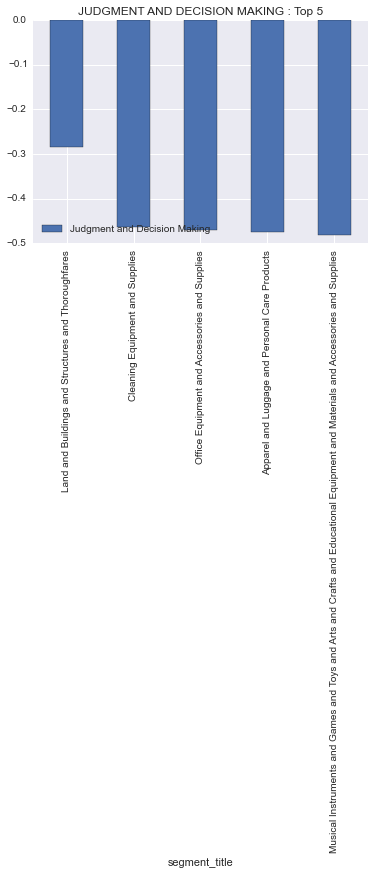

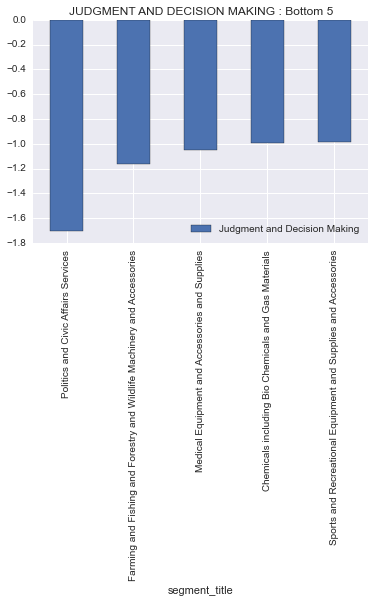

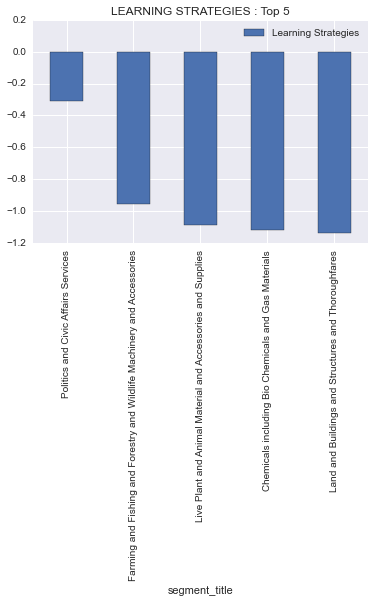

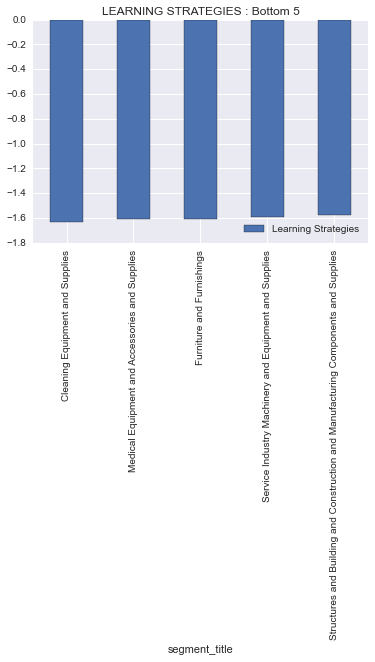

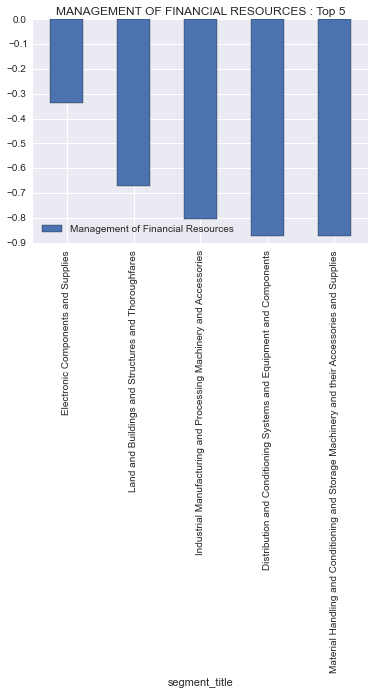

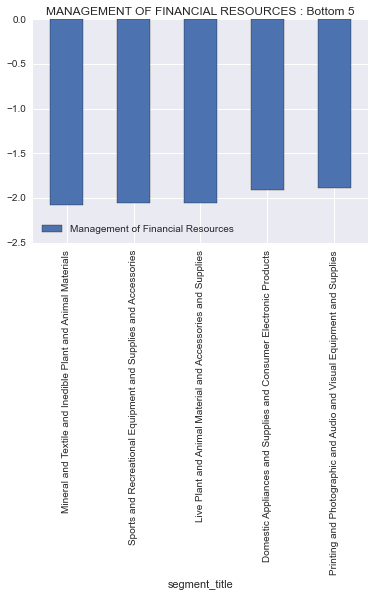

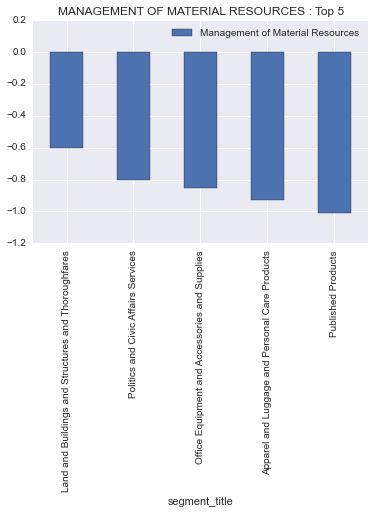

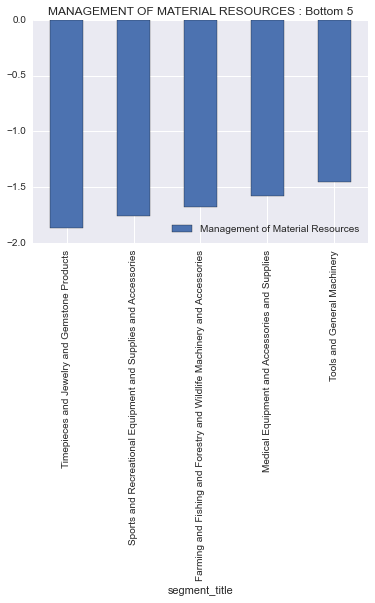

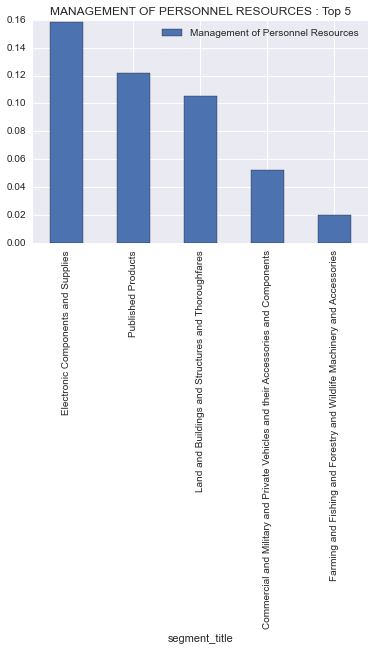

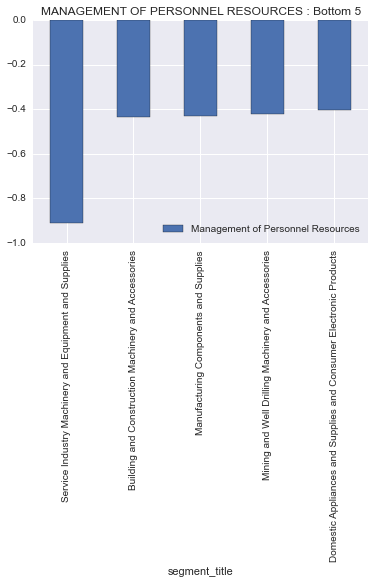

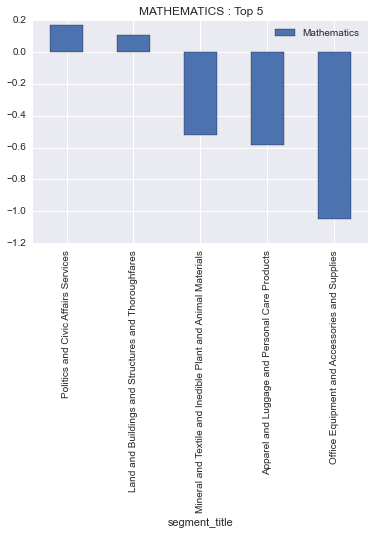

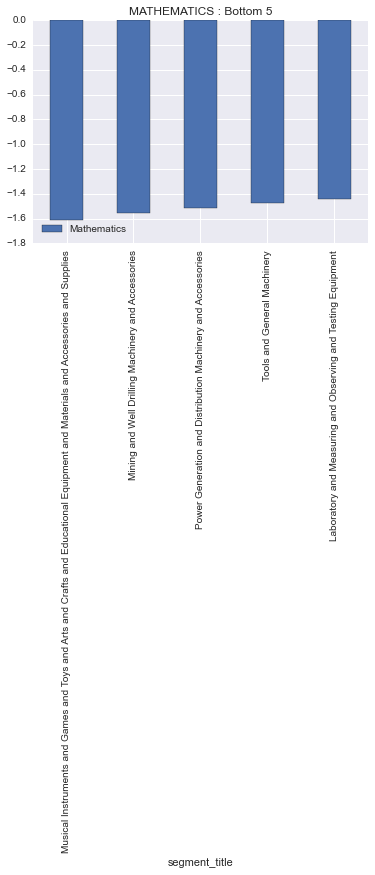

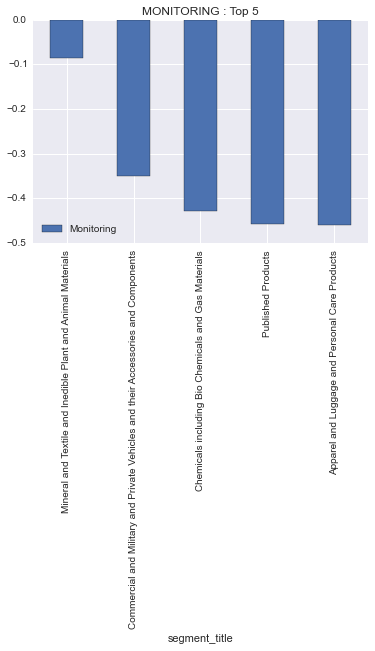

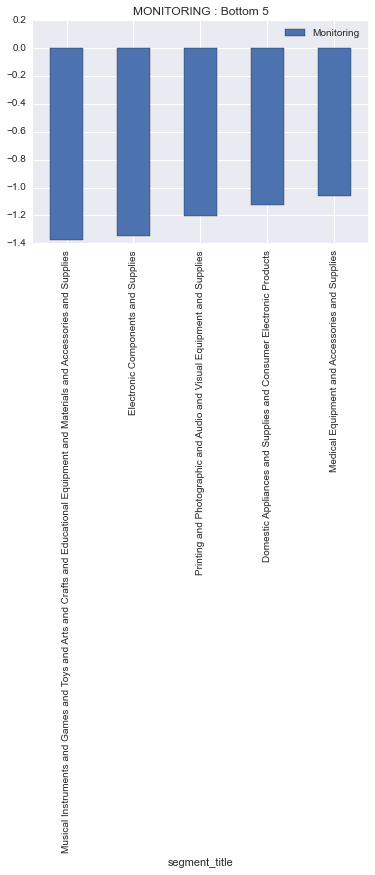

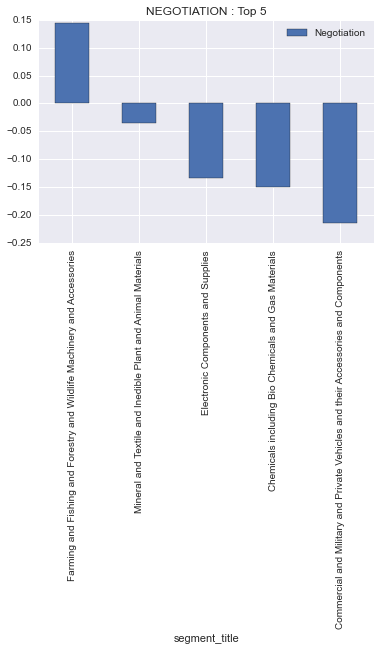

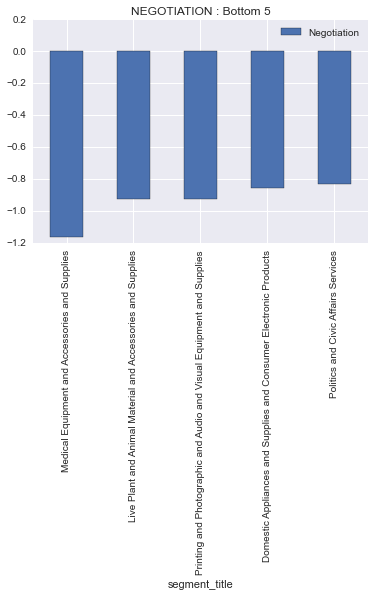

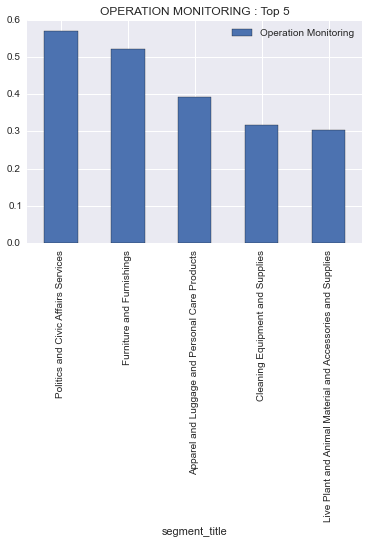

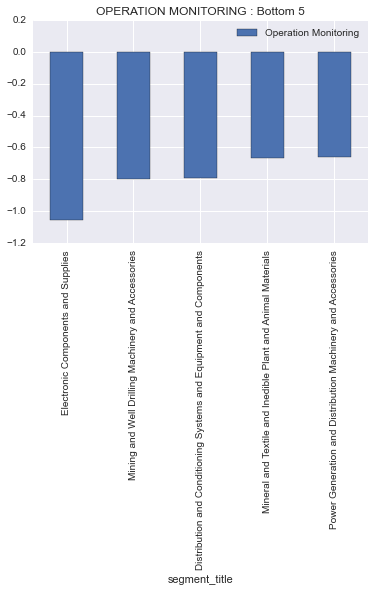

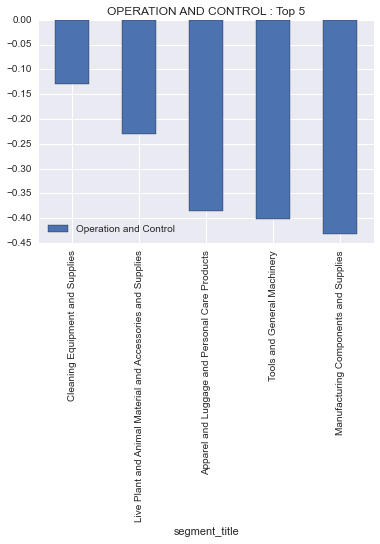

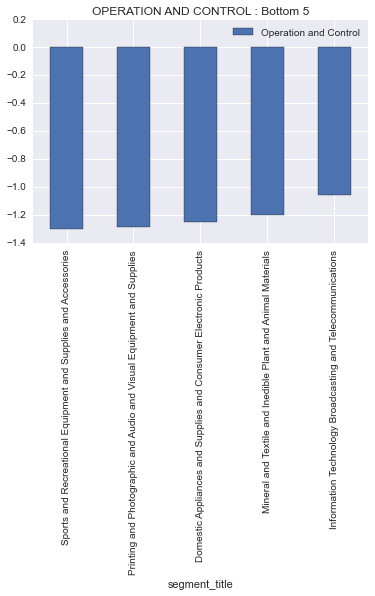

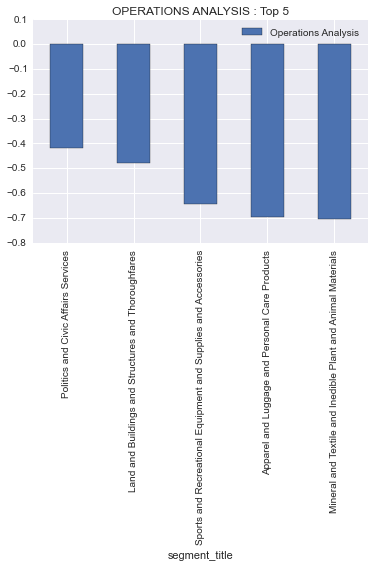

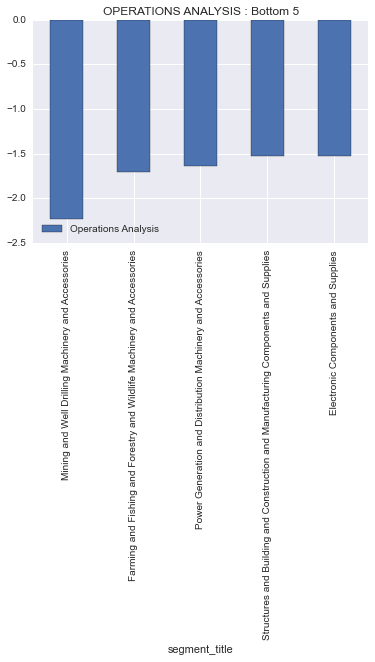

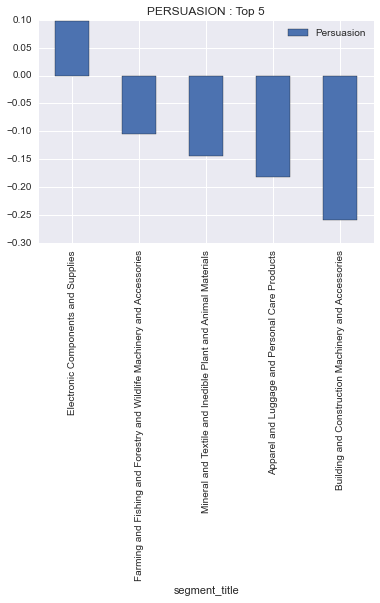

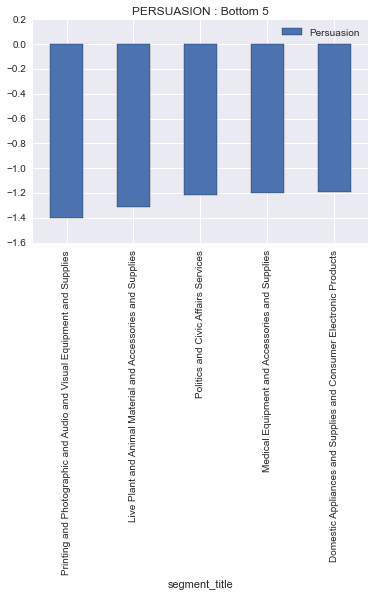

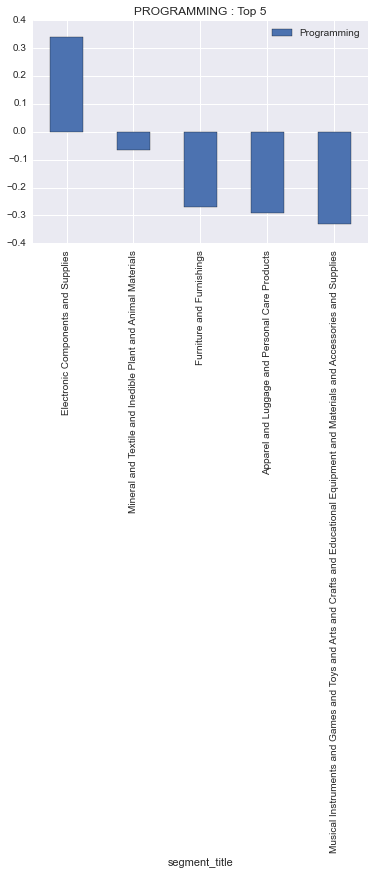

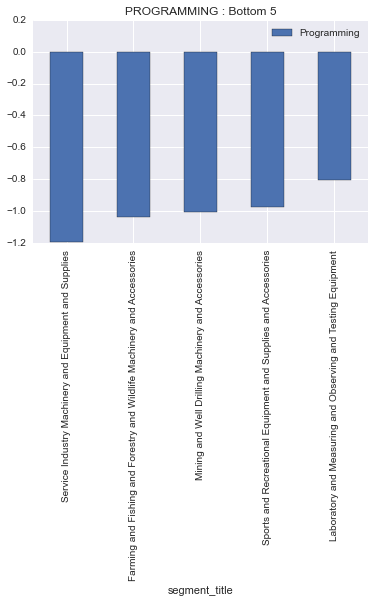

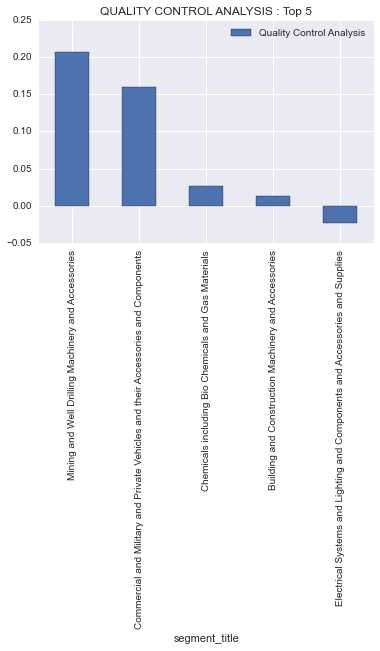

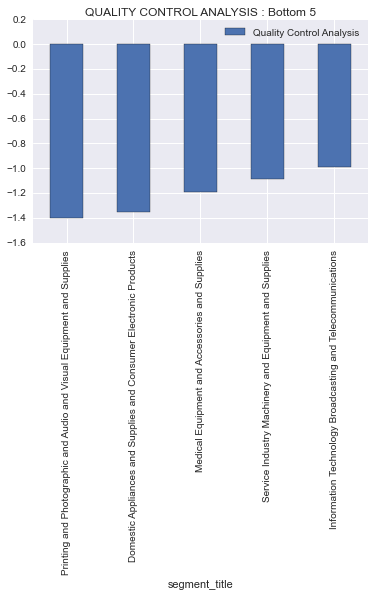

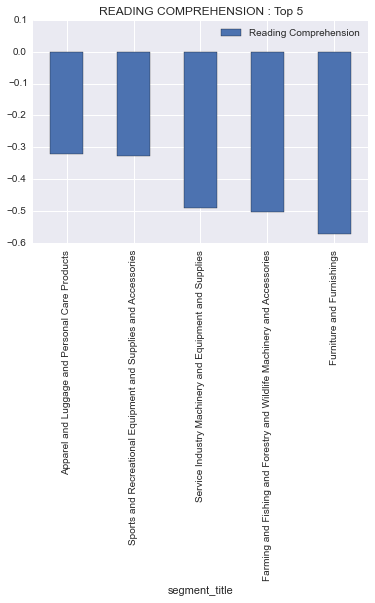

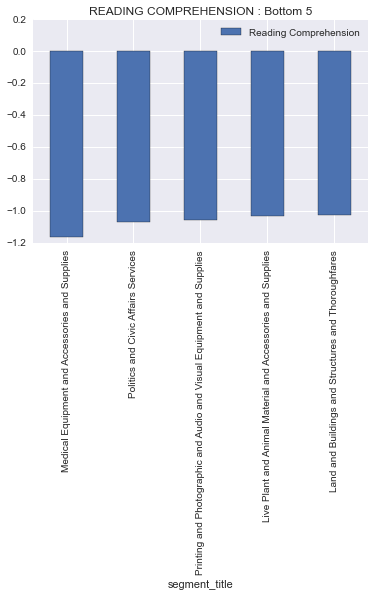

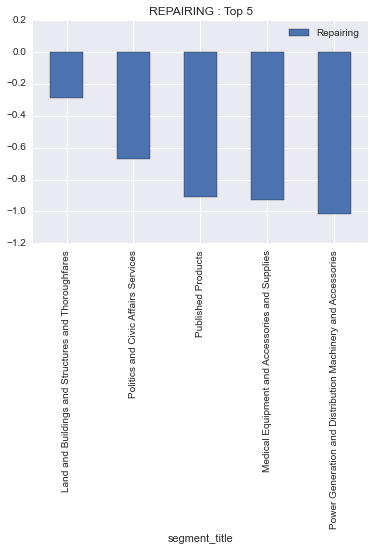

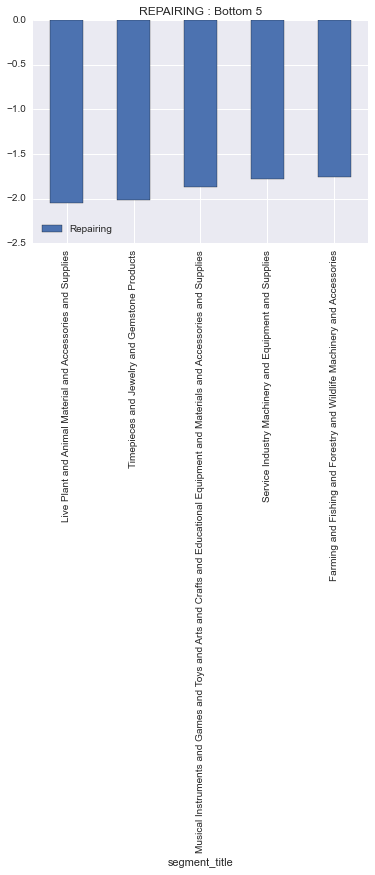

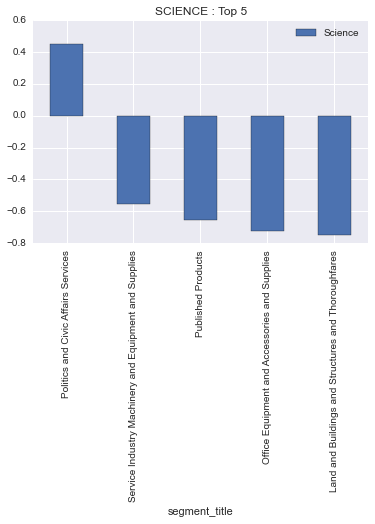

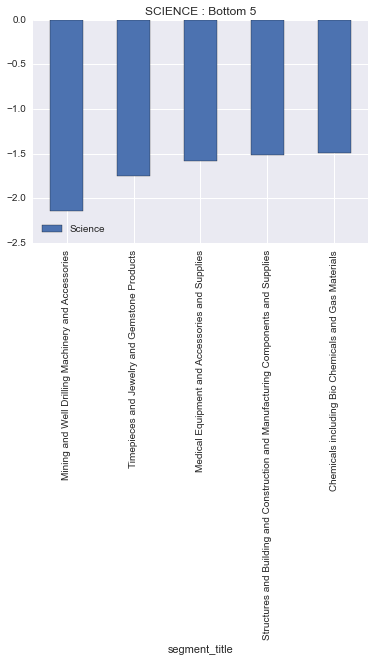

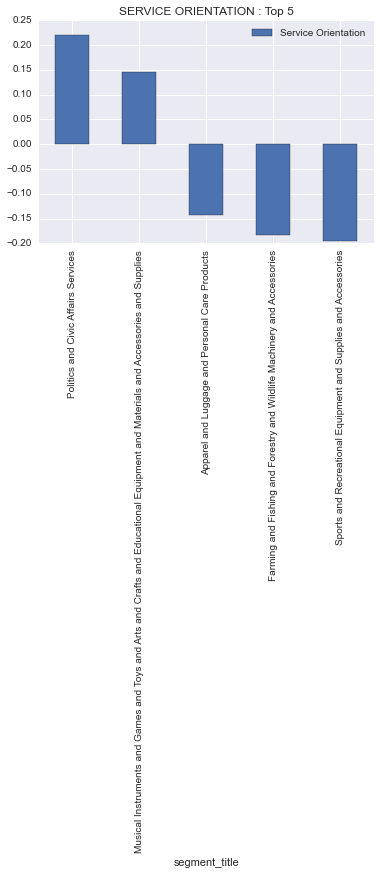

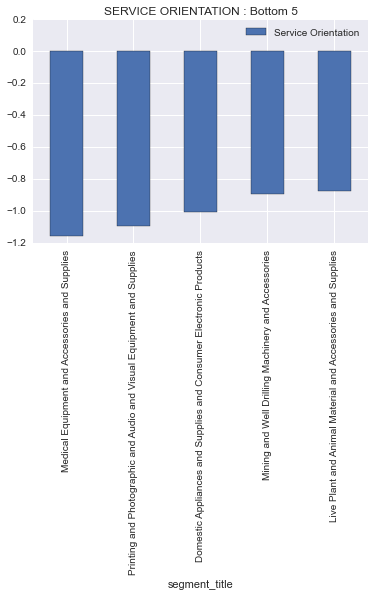

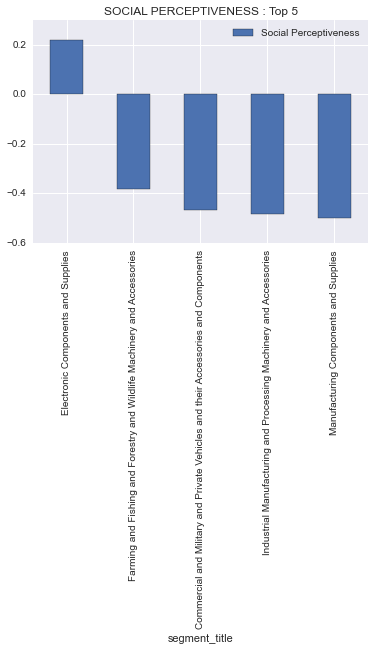

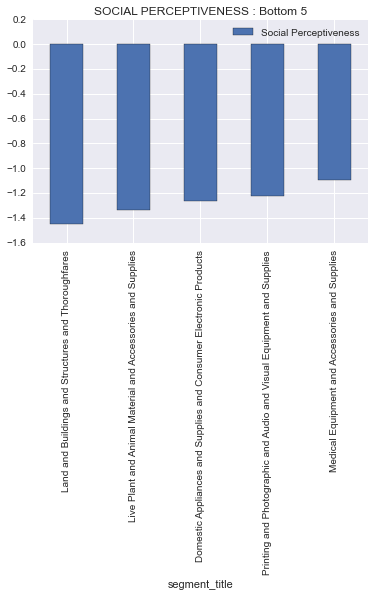

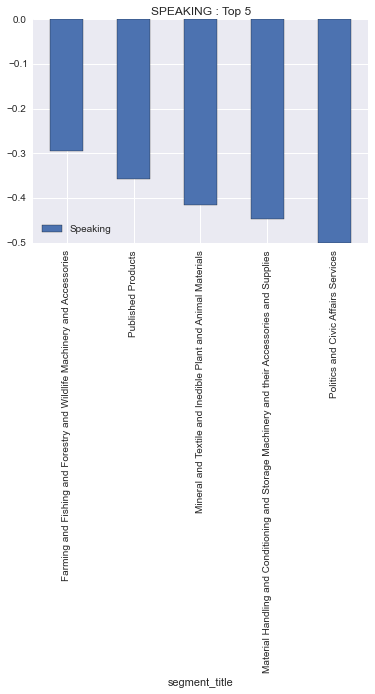

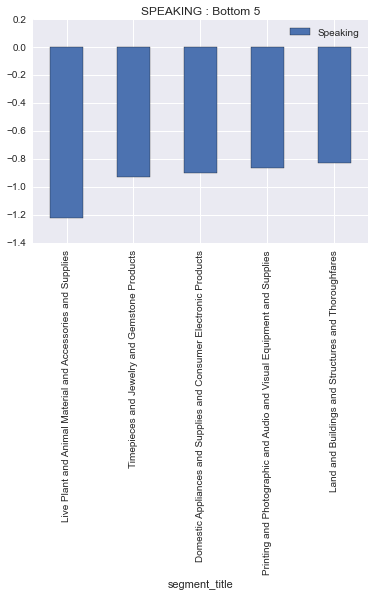

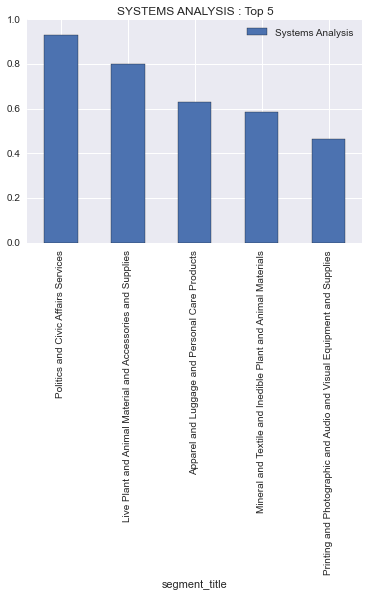

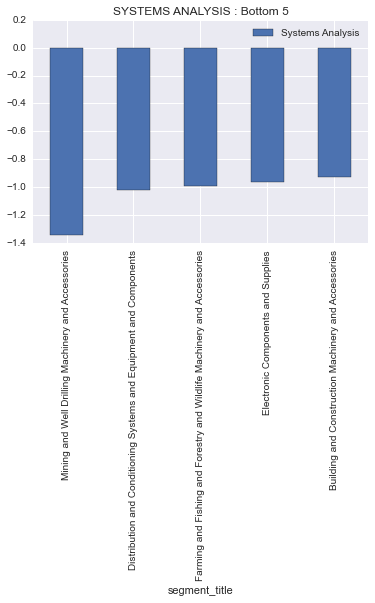

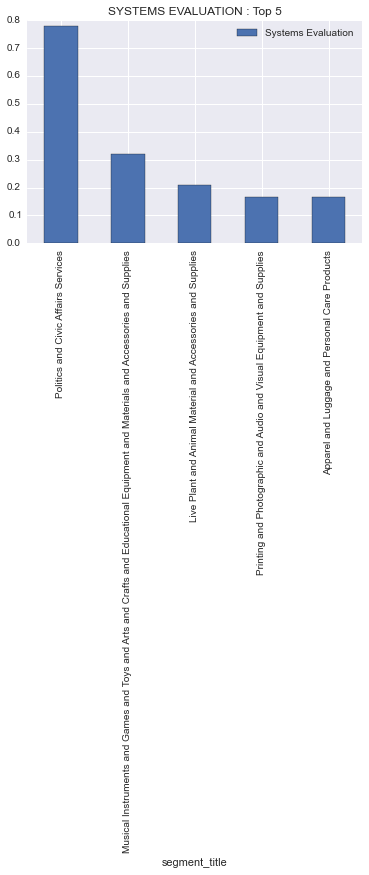

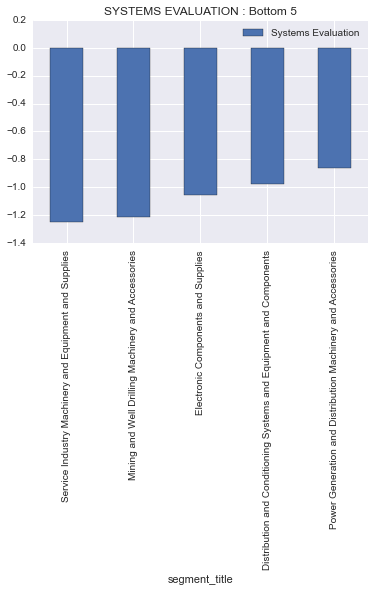

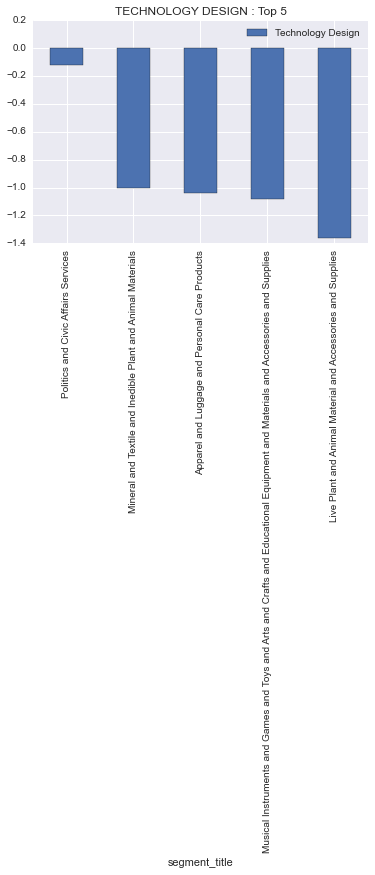

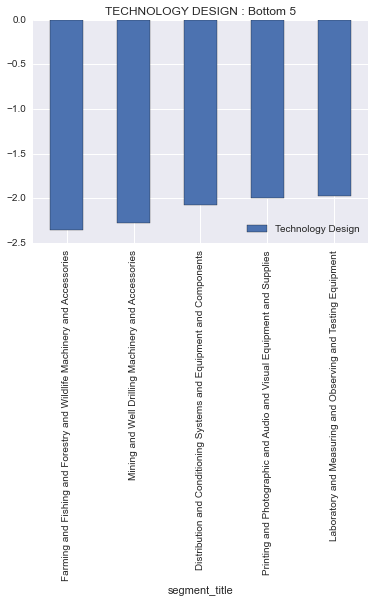

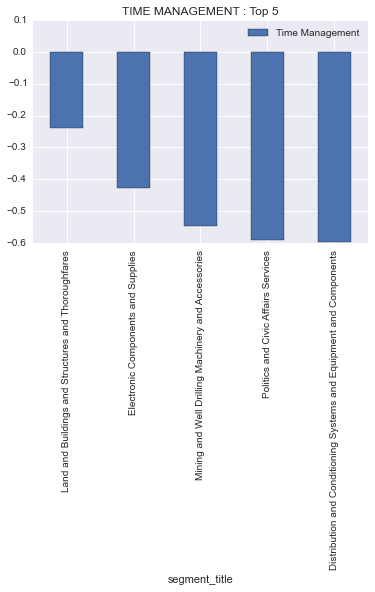

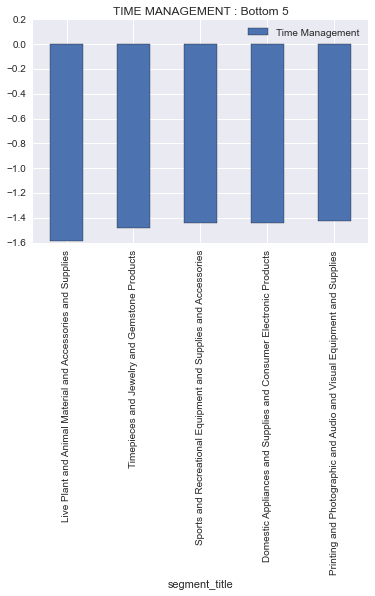

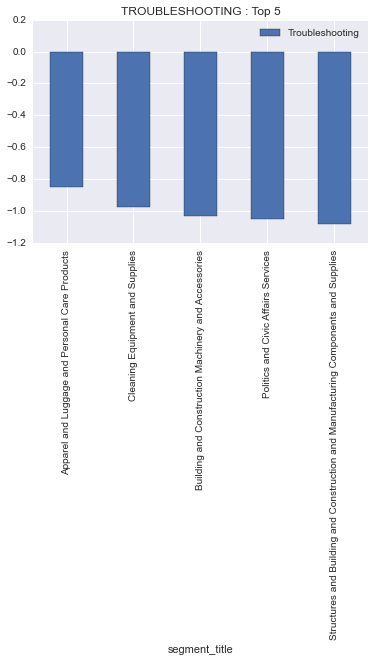

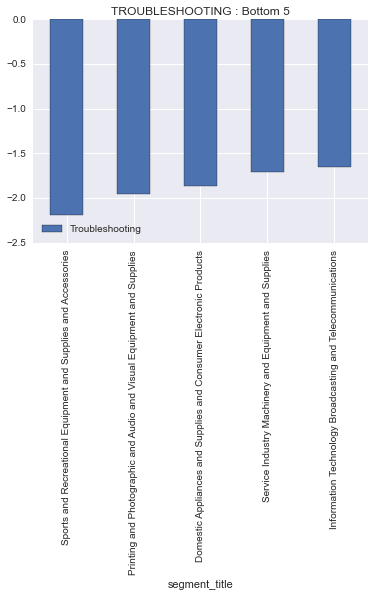

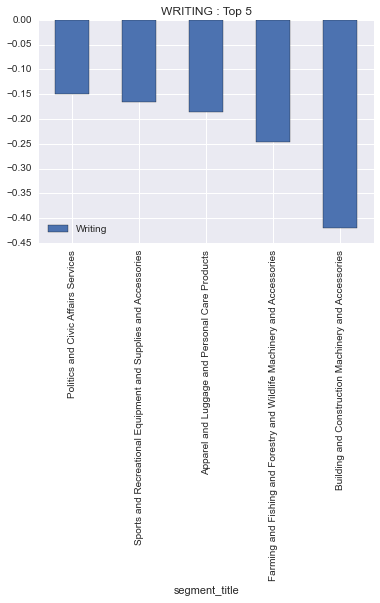

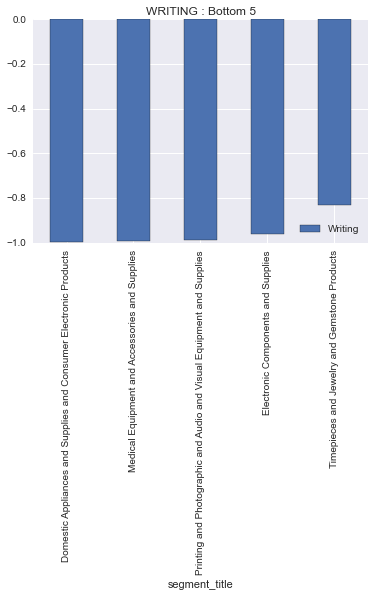

In [29]:
plot_charts(merged, pct_diff)

In [24]:
rank_diff.mean(axis = 0).sort(ascending = False)

/Users/Logan/anaconda/envs/dev/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


In [25]:
list(abs_diff.columns)

['Active Learning',
 'Active Listening',
 'Complex Problem Solving',
 'Coordination',
 'Critical Thinking',
 'Equipment Maintenance',
 'Equipment Selection',
 'Installation',
 'Instructing',
 'Judgment and Decision Making',
 'Learning Strategies',
 'Management of Financial Resources',
 'Management of Material Resources',
 'Management of Personnel Resources',
 'Mathematics',
 'Monitoring',
 'Negotiation',
 'O*NET-SOC Code',
 'Operation Monitoring',
 'Operation and Control',
 'Operations Analysis',
 'Persuasion',
 'Programming',
 'Quality Control Analysis',
 'Reading Comprehension',
 'Repairing',
 'Science',
 'Service Orientation',
 'Social Perceptiveness',
 'Speaking',
 'Systems Analysis',
 'Systems Evaluation',
 'Technology Design',
 'Time Management',
 'Troubleshooting',
 'Writing']

#∆TECHNOLOGY gb SKILL (2/3)

In [26]:
merged.head()

,O*NET-SOC Code,T2 Type,T2 Example,Commodity Code,Commodity Title,Title_x,broad_group,minor_group,major_group,broad_title,...,class_code,family_code,class_title,family_title,segment_title,automation_15,automation_9,delta,delta_pct,Title_y
0,17-3023.03,Tools,bench lathes,23242304,tracer duplicating contouring lathe,Electrical Engineering Technicians,17-3020,17-3000,17-0000,"Engineering Technicians, Except Drafters",...,23242300,23240000,Lathes and turning centers,Metal cutting machinery and accessories,Industrial Manufacturing and Processing Machin...,2,2.6,-0.6,-0.230769,Electrical Engineering Technicians
1,17-3023.03,Tools,brushless direct current dc motors,26101209,brushless motor dc,Electrical Engineering Technicians,17-3020,17-3000,17-0000,"Engineering Technicians, Except Drafters",...,26101200,26100000,Electric direct current DC motors,Power sources,Power Generation and Distribution Machinery an...,2,2.6,-0.6,-0.230769,Electrical Engineering Technicians
2,17-3023.03,Tools,computerized numerical control cnc machining c...,23101513,milling machines,Electrical Engineering Technicians,17-3020,17-3000,17-0000,"Engineering Technicians, Except Drafters",...,23101500,23100000,Machinery for working wood and stone and ceram...,Raw materials processing machinery,Industrial Manufacturing and Processing Machin...,2,2.6,-0.6,-0.230769,Electrical Engineering Technicians
3,17-3023.03,Tools,desoldering stations,23271607,automatic soldering machine,Electrical Engineering Technicians,17-3020,17-3000,17-0000,"Engineering Technicians, Except Drafters",...,23271600,23270000,Soldering machines,Welding and soldering and brazing machinery an...,Industrial Manufacturing and Processing Machin...,2,2.6,-0.6,-0.230769,Electrical Engineering Technicians
4,17-3023.03,Tools,dual power supplies,26111611,auxiliary generator,Electrical Engineering Technicians,17-3020,17-3000,17-0000,"Engineering Technicians, Except Drafters",...,26111600,26110000,Power generators,Batteries and generators and kinetic power tra...,Power Generation and Distribution Machinery an...,2,2.6,-0.6,-0.230769,Electrical Engineering Technicians
